In [0]:
import numpy
from matplotlib import pyplot
from scipy import stats
import torch
from torch import nn, optim
from torch.distributions.normal import Normal
from tqdm import tqdm_notebook
from torch.utils.data import DataLoader, TensorDataset

## Time series model

### Linear Model (Generalized)

The linear model is optimized to return a linear combination of the inputs so that the specified loss function is minimized. 

$$
    f(x) = \mathbf{w}^\top \mathbf{x} + b
$$

where $\mathbf{x}=(x^{(t)},...,x^{(t-p)})$. 

Sometimes, it is appropriate to apply a transformation $g$ to the linear combination in order to optimize the model more efficiently.

$$
    f(x) = g(\mathbf{w}^\top \mathbf{x} + b)
$$

where $g$ is a non linear transformation or the identity function.

In [0]:
class GLM(nn.Module):
    def __init__(self, input_size, output_activation_fn=None):
        super().__init__()
        self.linear = nn.Linear(input_size, 1, bias=True)
        if output_activation_fn:
            self.output_activation_fn = getattr(torch, activation_fn)
        else:
            self.output_activation_fn = lambda x: x
        
    def forward(self, x):
        o = self.linear(x).squeeze()
        return self.output_activation_fn(o)
    
    @torch.no_grad()
    def predict(self, x):
        return self.eval().forward(x).cpu()

### Feedforward neural network

The parameters of the Neural networks are optimized to map the input to the target by applying non-linear transformation to the input allowing the model to learn more complex relation between the inputs and the targets.

\begin{align}
    \mathbf{h} =& g_1(\mathbf{W} \mathbf{x} + b_1)\\
    \hat{y} =& g_2(\mathbf{w}^\top \mathbf{h} + b_2)
\end{align}

In [0]:
class FNN(nn.Module):
    def __init__(self, input_size, output_activation_fn=None):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 1, bias=True)
        self.linear2 = nn.Linear(512, 512, bias=True)
        self.linear3 = nn.Linear(512, 1, bias=True)

        if output_activation_fn:
            self.output_activation_fn = getattr(torch, output_activation_fn)
        else:
            self.output_activation_fn = lambda x: x
        
    def forward(self, x):
        h1 = torch.relu(self.linear1(x))
        h2 = torch.relu(self.linear2(h1))
        o = self.linear3(h2)
        return self.output_activation_fn(o).squeeze()
    
    @torch.no_grad()
    def predict(self, x):
        return self.eval().forward(x).cpu()

### Recurrent Neural Network

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, output_activation_fn=None):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=28, num_layer=1, bias=True)
        self.fnn = nn.Linear(in_features=28, out_features=1)
        
        if output_activation_fn:
            self.output_activation_fn = getattr(torch, output_activation_fn)
        else:
            self.output_activation_fn = lambda x: x
        
    def forward(self, x):
        h, _ = self.rnn(x)
        o = self.fnn(h)
        return self.output_activation_fn(o).squeeze()
    
    @torch.no_grad()
    def predict(self, x):
        return self.eval().forward(x).cpu()

## Example 1: Synthetic Data

### 1.1 Learning the $\sin()$ function

#### Generate data

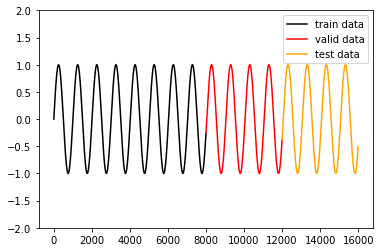

In [0]:
DATA_SIZE = 16000
TRAIN_SIZE = 8000
VALID_SIZE = 4000
TEST_SIZE = 4000

# Generate data points 
data = numpy.sin(numpy.linspace(start=0, stop=100, num=DATA_SIZE))

train_data = data[:TRAIN_SIZE]
valid_data = data[TRAIN_SIZE:TRAIN_SIZE+VALID_SIZE]
test_data = data[TRAIN_SIZE+VALID_SIZE:DATA_SIZE]

pyplot.plot(range(TRAIN_SIZE), train_data, color='black')
pyplot.plot(range(TRAIN_SIZE, TRAIN_SIZE+VALID_SIZE), valid_data, color='red')
pyplot.plot(range(TRAIN_SIZE+VALID_SIZE, DATA_SIZE), test_data, color='orange')
pyplot.ylim(-2, 2)
pyplot.legend(['train data', 'valid data', 'test data'])
pyplot.show()

#### Problem Statement

Our goal is to predice the value of the next points based on the value of the past $p$ points. 

$$
    f\colon (x^{(t)},...,x^{(t-p)})^\top \mapsto x^{(t+1)}
$$

#### Preprocessing

Currently, we have 16000 points $\mathbf{X}=(x^{(1)},...,x^{(16000)})$. A more convenient way to arrange the data for the optimization is to have each example in a different row:

$$
    \begin{pmatrix}
        x^{(1)} & \cdots & x^{(p)} \\
        x^{(2)} & \cdots & x^{(p+1)} \\
        \vdots & \ddots & \vdots \\
        x^{(T-p)} & \cdots & x^{(T)}
    \end{pmatrix}, 
    y = \begin{pmatrix}
        y^{(1)} \\
        y^{(2)} \\
        \vdots \\
        y^{(T)}
    \end{pmatrix}
$$

In [0]:
def prepare_sequential_data(data, p):
    source_data, target_data = [], []
    for i in range(p, len(data)):
        src = data[i-p:i]
        trg = data[i]
        source_data.append(src)
        target_data.append(trg)
    source_data = torch.tensor(source_data, dtype=torch.float32)
    target_data = torch.tensor(target_data, dtype=torch.float32)
    return source_data, target_data                

In [0]:
train_x, train_y = prepare_sequential_data(train_data, p=4)
train_x, train_y

(tensor([[ 0.0000,  0.0063,  0.0125,  0.0188],
         [ 0.0063,  0.0125,  0.0188,  0.0250],
         [ 0.0125,  0.0188,  0.0250,  0.0312],
         ...,
         [-0.3014, -0.2954, -0.2894, -0.2834],
         [-0.2954, -0.2894, -0.2834, -0.2774],
         [-0.2894, -0.2834, -0.2774, -0.2714]]),
 tensor([ 0.0250,  0.0312,  0.0375,  ..., -0.2774, -0.2714, -0.2654]))

#### Optimization

We will optimize the different models such that the mean squared error between the predictions and the targetes is minimized, i.e. 

$$
    \mathcal{L}(\theta) = \sum_{t=p}^T(f(\mathbf{x}_{t:t-p}) - y^{(t)})^2
$$

where $\mathbf{x}_{t:t-p}=(x^{(t)},...,x^{(t-p)})^\top$

In [0]:
def train_step(x, y, model, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    yhat = model(x)
    loss = loss_fn(yhat, y)
    loss.backward()
    optimizer.step()

def valid_step(x, y, model, loss_fn):
    model.eval()
    batch_size = x.shape[0]
    yhat = model(x)
    loss = loss_fn(yhat, y) * batch_size
    return loss.item()

def evaluate(dataloader, model, loss_fn, device):
    loss = 0.
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_loss = valid_step(batch_x, batch_y, model, loss_fn)
        loss += batch_loss
    return loss


def train_iter(train_loader, model, optimizer, loss_fn):
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        train_step(batch_x, batch_y, model, optimizer, loss_fn)


def train(train_loader, valid_loader, model, optimizer, loss_fn, max_iter, device):
    with tqdm_notebook(range(max_iter), unit=' epoch') as progressbar:
        for i in range(1, max_iter+1):
            train_iter(train_loader, model, optimizer, loss_fn)
            train_loss = evaluate(train_loader, model, loss_fn, device)
            valid_loss = evaluate(valid_loader, model, loss_fn, device)
            progressbar.set_description(f'Iter: {i}, Train MSE: {train_loss:.4f}, Valid MSE: {valid_loss:.4f}')
            progressbar.update()

In [0]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {DEVICE}')

LAG = 30

TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = VALID_SIZE
MAX_ITER = 100
STEP_SIZE = 0.001 # learning rate

device: cuda


In [0]:
train_x, train_y = prepare_sequential_data(train_data, p=LAG)
valid_x, valid_y = prepare_sequential_data(valid_data, p=LAG)
test_x, test_y = prepare_sequential_data(test_data, p=LAG)

train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=TRAIN_BATCH_SIZE)
valid_loader = DataLoader(TensorDataset(valid_x, valid_y), batch_size=VALID_BATCH_SIZE)
test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=VALID_BATCH_SIZE)

#### GLM experiment

In [0]:
glm = GLM(input_size=LAG).to(DEVICE)
optimizer = torch.optim.Adam(glm.parameters(), lr=STEP_SIZE)
loss_fn = torch.nn.MSELoss()
train(train_loader, valid_loader, glm, optimizer, loss_fn, MAX_ITER, DEVICE)

#### Results

In [0]:
def plot_results(train_true, valid_true, train_pred, valid_pred):
    train_size = len(train_true)
    valid_size = len(valid_true)

    train_range = range(train_size)
    valid_range = range(train_size, train_size+valid_size)

    pyplot.plot(train_range, train_true, color='black')
    pyplot.plot(valid_range, valid_true, color='black', linestyle='--')
    
    pyplot.scatter(train_range, train_pred, color='red', marker='.')
    pyplot.scatter(valid_range, valid_pred, color='red', marker='.')

    pyplot.ylim(-2, 2)
    pyplot.legend(['train true', 'valid true', 'train pred', 'valid pred'])
    pyplot.show()

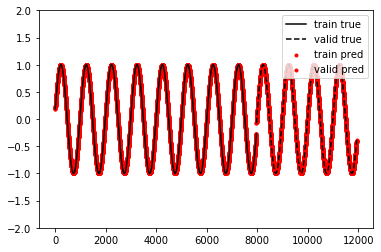

In [0]:
train_pred = glm.predict(train_x.to(DEVICE))
valid_pred = glm.predict(valid_x.to(DEVICE))

plot_results(train_y, valid_y, train_pred, valid_pred)

#### Iterative prediction

In [0]:
valid_predictions = []

x = valid_x[0]
for _ in range(VALID_SIZE):
    src = x[-LAG:].to(DEVICE)
    yhat = model.predict(src)
    valid_predictions,append(yhat.item())
    x = torch.cat([x, yhat])

In [0]:
x = valid_x[0]

yhat = glm.predict(x.to(DEVICE))

torch.cat([])

-0.07477577030658722

## 1.2 Variance Forecasting

### Generating data with time dependencies

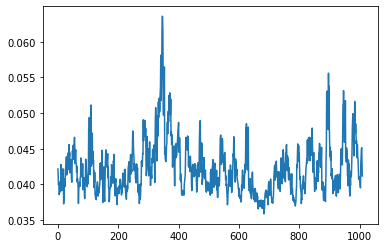

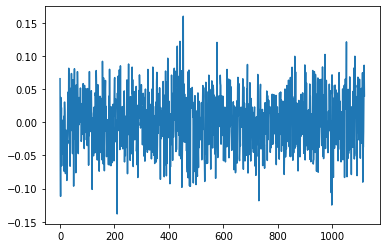

In [0]:
LAG = 10
SKIP = 100
INIT_VOL = 0.05

coeffs_input = numpy.random.uniform(0, 0.75, LAG)
coeffs_sigma = numpy.random.uniform(0, 0.25, LAG)

series = numpy.random.normal(0, INIT_VOL, LAG)
true_sigma = numpy.array([INIT_VOL] * LAG)
X = []
y = []

for _ in range(1000+LAG+SKIP):
    source_input = series[-LAG:]
    source_sigma = true_sigma[-LAG:]
    X.append(source_input)
    sigma = 0.03 + numpy.dot(coeffs_input, source_input**2) + numpy.dot(coeffs_input, source_sigma**2)
    true_sigma = numpy.append(true_sigma, sigma)
    x = numpy.random.normal(0, sigma)
    series = numpy.append(series, x)

y = series[LAG+SKIP:]
true_sigma = true_sigma[LAG+SKIP:]
X = X[SKIP:]

X = numpy.array(X)

pyplot.plot(true_sigma)
pyplot.show()

pyplot.plot(series)
pyplot.show()

In [0]:
logpdf_true = stats.norm.logpdf(y, loc=numpy.zeros_like(y), scale=true_sigma).mean()
print(logpdf_true)

1.7686935775215187


In [0]:
pred_sigma_naive = numpy.std(X, axis=1)
logpdf_naive = stats.norm.logpdf(y, loc=numpy.zeros_like(y), scale=pred_sigma_naive).mean()
print(logpdf_naive)

1.6742062394420516


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

X_tensor = torch.from_numpy(X).type(torch.float32)
y_tensor = torch.from_numpy(y).type(torch.float32)

dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)

device: cuda


In [0]:
MAX_ITER = 5000
LR = 0.001
BATCH_SIZE = 28

In [0]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE if BATCH_SIZE else len(dataset))
rnn = RNN().to(device)
optimizer = optim.Adam(glm.parameters(), lr=LR)

with tqdm_notebook(range(MAX_ITER), unit=' epoch') as progressbar:
    for i in range(1, MAX_ITER+1):
        for batch in dataloader:
            train_batch(glm, optimizer, *batch)
        loss = evaluate(glm, dataloader)
        progressbar.set_description(f'Iter: {i}, cross-entropy: {loss:.4f}')
        progressbar.update()

1.7722617951380926


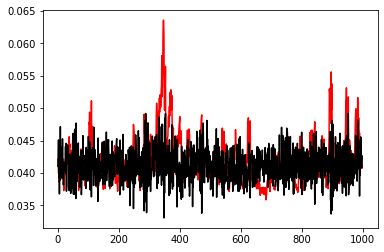

In [0]:
pred_sigma_glm = glm.predict(X_tensor.to(device)).numpy().squeeze()
logpdf_glm = stats.norm.logpdf(y, loc=numpy.zeros_like(y), scale=pred_sigma_glm).mean()
print(logpdf_glm)

pyplot.plot(true_sigma[:1000], color='red')
pyplot.plot(pred_sigma_glm[:1000], color='black')
pyplot.show()

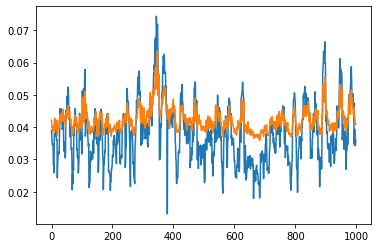

In [0]:
pyplot.plot(pred_sigma_naive[:1000])
pyplot.plot(true_sigma[:1000])